In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
import netCDF4 as nc
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
from shapely.geometry import Point
from datetime import datetime, timedelta

In [2]:
file = nc.Dataset("dades/DADES_CALIOPE_buenos/NO2/sconcno2_2023010100.nc")
#sf = shp.Reader("dades/LimitsAdministratius/Catalunya/divisions-administratives-v2r1-catalunya-5000-20240705")
div_gdf = gpd.read_file("dades/LimitsAdministratius/Catalunya/divisions-administratives-v2r1-catalunya-5000-20240705.shp")
lu = rio.open("dades/LandUse/MUCSC_2022_10_m_v_3.tif")
traffic_bcn = gpd.read_file("dades/OpenTransportMap/Barcelona/roadlinks_ES511.shp") #Trafficvol

In [3]:
ca_shape = file['sconcno2'].shape
ca_dat = np.reshape(file['sconcno2'], (48, -1))
ca_lon = np.ravel(file['lon'])
ca_lat = np.ravel(file['lat'])
print(ca_shape)
print(ca_lon.shape)

(48, 1, 298, 278)
(82844,)


Warning 1: TIFFFetchNormalTag:IO error during reading of "GeoKeyDirectory"; tag ignored


(25949, 26940)


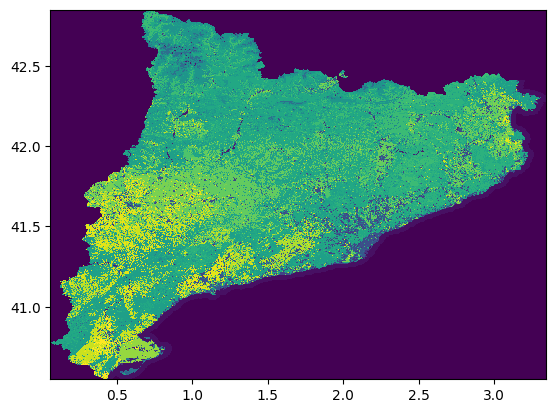

In [4]:
#lu_x = [(lu.transform * (i, 0))[0] for i in range(lu.width)]
lu_x = np.vectorize(lambda x: (lu.transform * (x, 0))[0])(np.arange(max(lu.width, lu.height)))
lu_y = np.vectorize(lambda y: (lu.transform * (0, y))[1])(np.arange(max(lu.height, lu.width)))
lu_gdf = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for lon, lat in zip(lu_x, lu_y)]},
    crs="EPSG:25831"
)
lu_gdf = lu_gdf.to_crs(4326)
lu_lon = lu_gdf.geometry.x.to_numpy()
lu_lat = lu_gdf.geometry.y.to_numpy()
lu_lon = lu_lon[:lu.width]
lu_lat = lu_lat[:lu.height]
lu_dat = lu.read(1)
print(lu_dat.shape)
plt.pcolormesh(lu_lon[:lu.width:50], lu_lat[:lu.height:50], lu_dat[::50, ::50])
plt.show()

In [5]:
df_AMS_sconcno2 = pd.read_csv('dades/AMS_Observacions/XVPCA_info_sconcno2_2023.csv') #lat lon of stations. Also if they are suburban/rural/urban-center
gdf = gpd.GeoDataFrame(traffic_bcn)

def get_min_dist(df, gdf): # -> Input> Dataframe with .csv with station location, gdf with lines which are the start / end of the road in lat,lon. Output is an array of the closest distance between a station and the road
    
    AMS_np = df
    AMS_np_lat = AMS_np[:,0]
    AMS_np_lon = AMS_np[:,1]
    lis = []
    lis_points = []

    AMS_fused = np.vstack((AMS_np_lon, AMS_np_lat)).T

    for element in AMS_fused:
        p = Point(element[0], element[1])
        lis_points.append([p])
    for point_coords in lis_points:
        point = Point(point_coords[0])
        elem = gdf['geometry'].distance(point)
        lis.append(elem.min())
    return(lis)

print (get_min_dist(np.array(np.vstack(([4],[50])).T), gdf))

/tmp/ipykernel_694140/1727336124.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  elem = gdf['geometry'].distance(point)


[np.float64(60.394527054835095)]


/home/joan/code/bitsxm/venv/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [6]:
lu_ponderacions = np.ones(26)
# INFRAESTRUCTURES VIARIES
lu_ponderacions[4] = 1.1
# URBANITZACIONS
lu_ponderacions[5] = 1.1
# ZONES URBANES
lu_ponderacions[6] = 1.2
# ZONES INDUSTRIALS I COMERCIALS
lu_ponderacions[7] = 1.3
# BOSCOS
lu_ponderacions[15:18] = [0.8]*3
# CONREUS I AGRICULTURA
lu_ponderacions[19:26] = [0.9]*7
print(lu_ponderacions)

[1.  1.  1.  1.  1.1 1.1 1.2 1.3 1.  1.  1.  1.  1.  1.  1.  0.8 0.8 0.8
 1.  0.9 0.9 0.9 0.9 0.9 0.9 0.9]


In [7]:
ca_tree = spatial.KDTree(np.vstack((np.ravel(ca_lon), np.ravel(ca_lat))).T)

In [ ]:
def find_nearest(array, value):
    return (np.abs(array - value)).argmin()
def find_nearestv(array, valuev):
    #n = array.size
    #return (np.abs(array - np.reshape(np.repeat(valuev,n),(-1,n)))).argmin(axis=1)
    values = np.array(valuev)
    return [
        find_nearest(array, value)
        for value in np.nditer(values)
    ]
def find_nearestp(lons, lats, lon, lat):
    pass
def predict(lon, lat, data):
    lu_lon_i = find_nearest(lu_lon, lon)
    lu_lat_i = find_nearest(lu_lat, lat)
    return data*lu_ponderacions[lu_dat[lu_lat_i][lu_lon_i]]
def predictv(lonv, latv, time):
    #lu_lon_iv = find_nearestv(lu_lon, lonv)
    #lu_lat_iv = find_nearestv(lu_lat, latv)
    ca_indexs = ca_tree.query(np.vstack((np.ravel(lonv), np.ravel(latv))).T)[1]
    return 1912.5 * ca_dat[time][ca_indexs]#* lu_ponderacions[lu_dat[lu_lat_iv, lu_lon_iv]]
    
predictv([2.5],[30],0)-ca_dat[0][0]

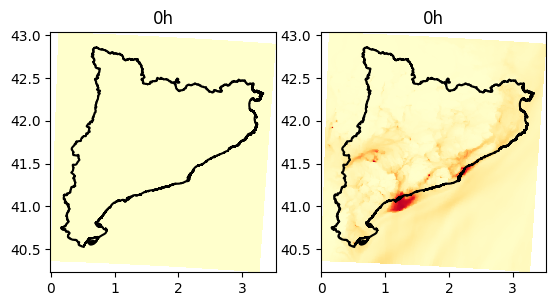

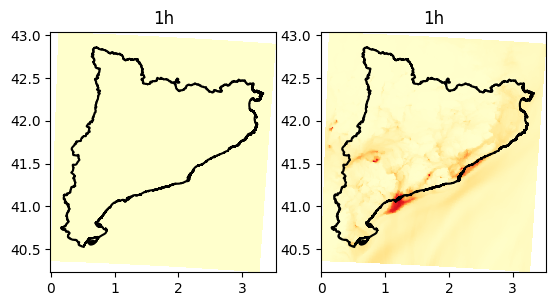

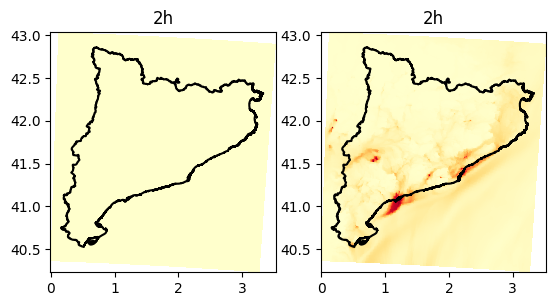

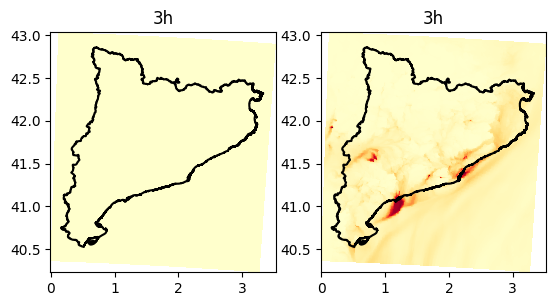

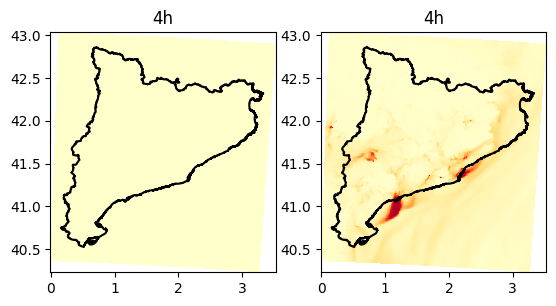

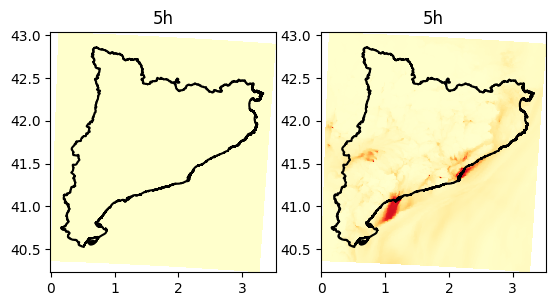

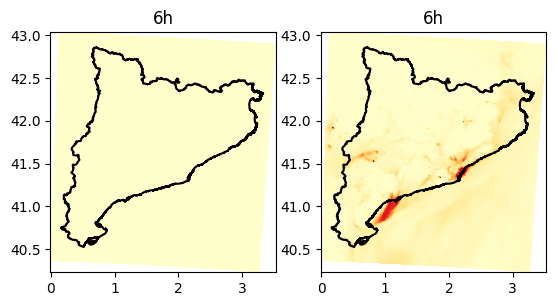

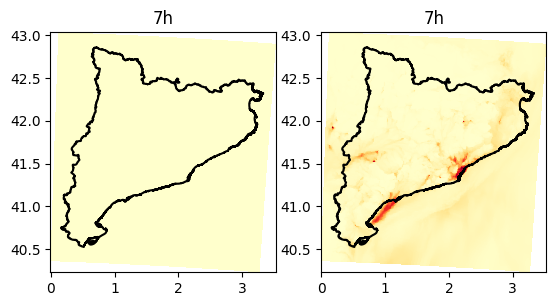

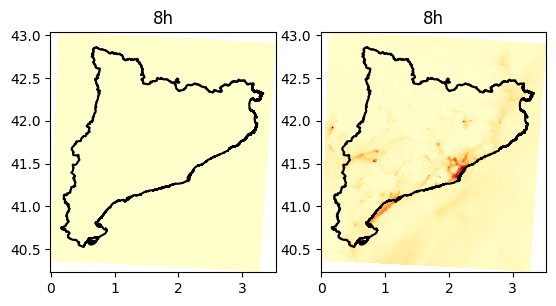

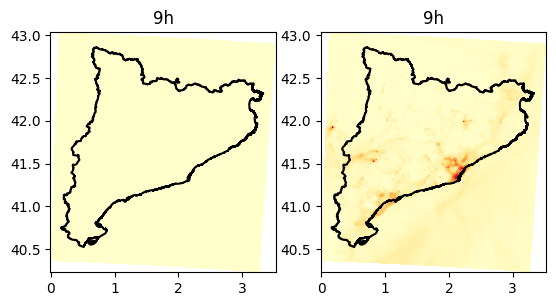

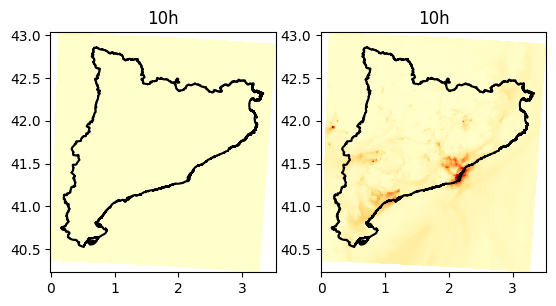

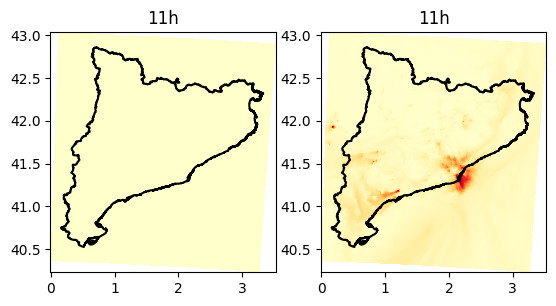

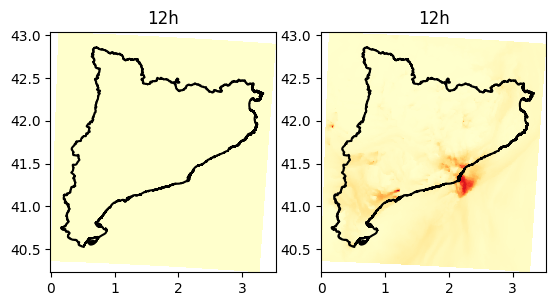

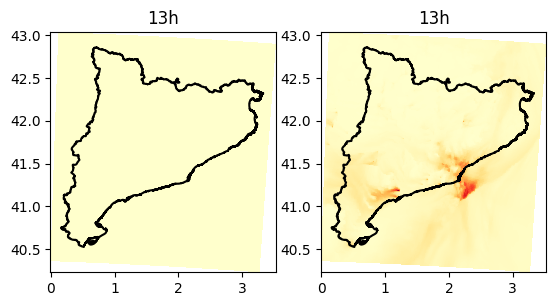

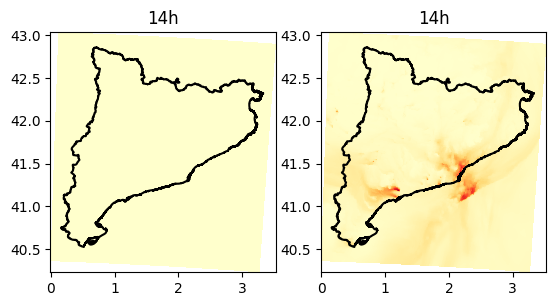

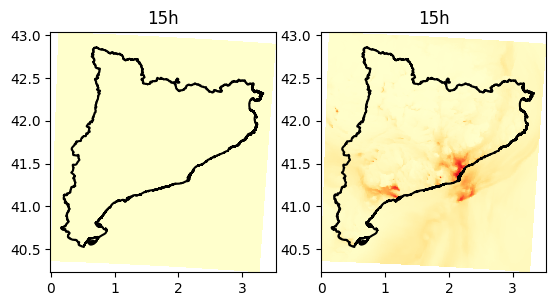

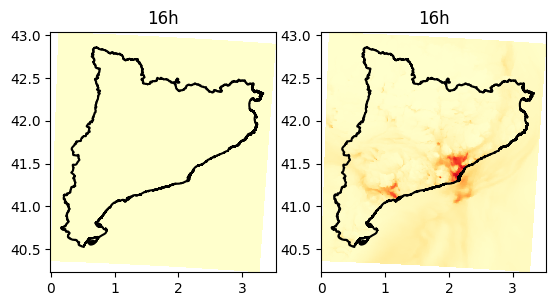

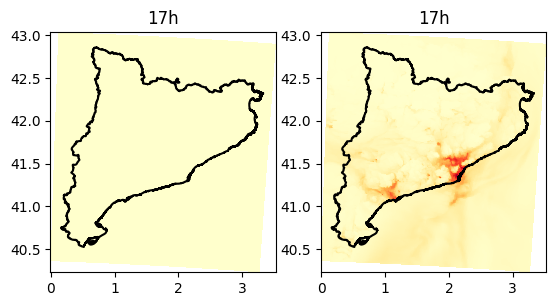

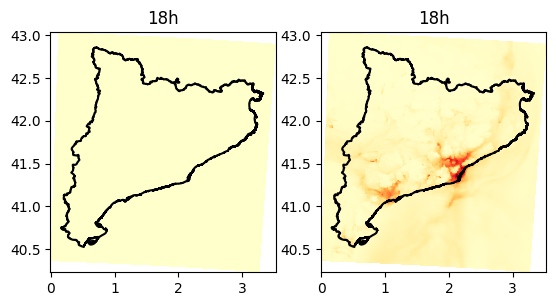

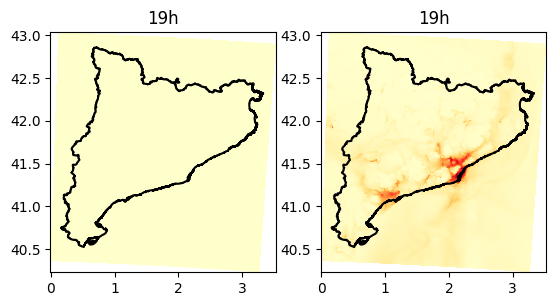

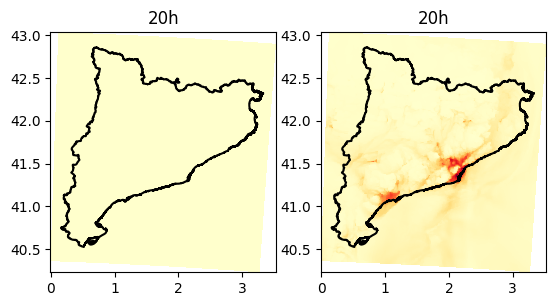

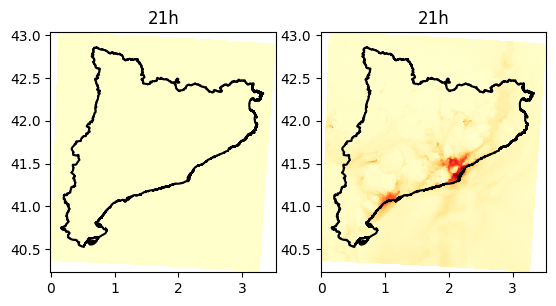

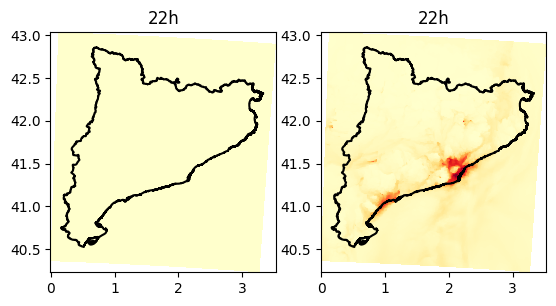

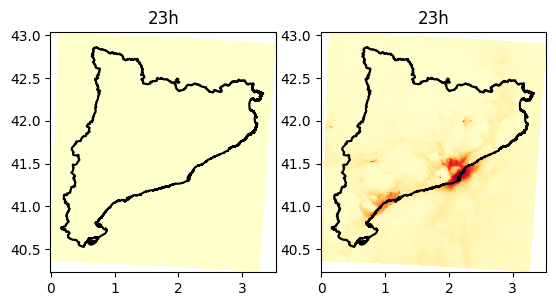

In [11]:
lon = file['lon']
lat = file['lat']
for h, dat in enumerate(ca_dat[0:24]):
    fig, ax = plt.subplots(1, 2)
    dat *= 1912.5
    pred_dat = predictv(ca_lon, ca_lat, h)
    _max = max(np.max(dat), np.max(pred_dat))
    ax[0].pcolormesh(lon, lat, np.reshape(dat, ca_shape[2:]), cmap='YlOrRd', vmin=0, vmax=_max)
    ax[1].pcolormesh(lon, lat, np.reshape(pred_dat, ca_shape[2:]), cmap='YlOrRd', vmin=0, vmax=_max)
    for axi in ax:
        axi.set_title(f"{h % 24}h")
        div_gdf.to_crs(4326).boundary.plot(ax=axi, color='k')
    plt.show()

In [35]:
def read_data(t):
    try:
        file = nc.Dataset(f"dades/DADES_CALIOPE_buenos/NO2/sconcno2_{t.strftime("%Y%m%d")}00.nc")
    except:
        return False
    ca_shape = file['sconcno2'].shape
    ca_dat = np.reshape(file['sconcno2'], (48, -1))
    ca_lon = np.ravel(file['lon'])
    ca_lat = np.ravel(file['lat'])
    return True
result = []
lons = [2.009802, 1.191975, 2.237875, 2.082141]
lats = [41.39216, 41.11588, 41.44398, 41.32177]
start = datetime(2023, 1, 1)
end = datetime(2024, 1, 1)
delta = timedelta(days=1)
i = 1
while start < end:
    if not read_data(start):
        pass
    for h in range(24):
        str = f"{start.strftime("%Y-%m-%d")} {h:02}:00"
        pred = predictv(lons, lats, h % 24)
        for j, (lon, lat) in enumerate(zip(lons, lats)):
            result.append((i, str, lat, lon, pred[j]))
            i += 1
    print(start.strftime("%Y-%m-%d"))
    start += delta
        
columns = ['id', 'date', 'lat', 'lon', 'concentration']
final_dat = pd.DataFrame(result,columns=columns)
final_dat.to_csv("result.csv", index=False)

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01